In [207]:
import pandas as pd
import seaborn as sn
from random import shuffle
import os
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [208]:
def generate_dataset(n_clusters: int, n_points: int = 100, std: float = 1.0, min: float = -10, max: float = 10, random_state : int = None):
    """
    generates a two dimensional set of points
    :param n_clusters: number of clusters to generate
    :param n_points: number of total points to generate for all clusters
    :param std: standard deviation of cluster points
    :param min: minimum point value
    :param max: maximum point value
    :param random_state: random generator seed
    :return: X, array of points shape (n_points, 2)
    :return: y, array of point cluster identity
    :return: centers, center point for each cluster
    """
    X, y, centers = make_blobs(n_samples=n_points, n_features=2, centers=n_clusters, cluster_std=std, center_box=(min, max), return_centers=True, random_state=random_state)
    return X, y, centers

In [237]:
"""
Requirements:
the input plot must without axes
"""
# Generate and save plot without axes
def generate_save_plot(n_clusters, n_points, std, random_state, plot_path, show=True):
    X, y, centers = generate_dataset(
        n_clusters = n_clusters, 
        n_points = n_points,
        std = std,
        random_state = random_state
    )
    plt.scatter(X[:, 0], X[:, 1])
    plt.axis('off') # to save plot without axes
    plt.savefig(plot_path)
    if show: plt.show()
    plt.clf()
    
    
    
# Load the image and convert to binary
def get_binary_plot(path):
    plot = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    bp = plot
    bp[plot == 255] = 0;
    bp[plot>0] = 255;
    return bp



# Generate random data for 2-n_clusters, each category has n_samples, out to specific folder
def generate_data(n_clusters, n_samples, folder):
    total_samples = (n_clusters - 1) * n_samples
    random_seeds = random.sample(range(total_samples * 10), total_samples)
    seed_index = 0
    for i in range(2, n_clusters + 1):
        for j in range(n_samples):
            seed = random_seeds[seed_index]
#             random_std = round(random.uniform(1.0), 2) # from 0.5-1.5
            random_points = random.randint(i*10, 1*100)
            generate_save_plot(i, random_points, 1.0, seed, 
                               '../plots/{}/{}_{}.png'.format(folder, i, j), False)
            seed_index += 1
            

            
# Load images to array and also its corresponding labels          
def load_data(folder):
    x = []
    y = []
    for image_name in os.listdir(folder):
        if ".png" in image_name:
            image_name_split = image_name.split('_')
            img_path = os.path.join(folder, image_name)
            img = get_binary_plot(img_path)
            resized = cv2.resize(img, (48,48), interpolation=cv2.INTER_AREA) # resize to 32 * 32
            scaled = resized/255.0 # rescale
            x.append(scaled)
            y.append(int(image_name_split[0])*1.0) # make the label as float for regression appraoch perform better
        else: 
            continue
    x = np.array(x)
    y = np.array(y)
    print(x.shape)
    print(y.shape)
    return x, y

In [278]:
generate_data(6, 300, 'training')
generate_data(6, 60, 'validation')
# generate_data(6, 50, 'test')

<Figure size 432x288 with 0 Axes>

In [279]:
size = 48
train_x, train_y = load_data('../plots/training')
val_x, val_y = load_data('../plots/validation')
test_x, test_y = load_data('../plots/test')
train_x = train_x.reshape(-1, size, size, 1)
val_x = val_x.reshape(-1, size, size, 1)
test_x = test_x.reshape(-1, size, size, 1)

# classification need one hot encoding
# train_y = to_categorical(train_y)
# val_y = to_categorical(val_y)

(1500, 48, 48)
(1500,)
(300, 48, 48)
(300,)
(250, 48, 48)
(250,)


In [280]:
def create_model(input_shape=(48,48,1), alpha=0.0001):
    # Build CNN model
    model = Sequential()
    model.add(Conv2D(input_shape=input_shape, filters = 32, kernel_size=(3, 3), activation='relu', padding='same')) 
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
#     model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#     model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
#     model.add(Dense(256, activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dense(7, activation='softmax')) # classification
    model.add(Dense(1)) # regression
    
    # classification approach
#     model.compile(
#         loss='categorical_crossentropy',
#         optimizer=Adam(lr=alpha),
#         metrics=['accuracy']
#     )
    
    # reg approach
    model.compile(
        loss='mean_absolute_error',
        optimizer=Adam(lr=alpha),
        metrics=['mae']
    )
    return model

In [281]:

model = create_model()
history = model.fit(train_x, train_y, validation_data = (val_x, val_y), batch_size=128, shuffle=True, epochs=300)
model.save('../saved_model/cnn_reg')

/Users/zhihengchang/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/300
12/12 [==============================] - 4s 288ms/step - loss: 3.9889 - mae: 3.9889 - val_loss: 3.9655 - val_mae: 3.9655
Epoch 2/300
12/12 [==============================] - 3s 277ms/step - loss: 3.9635 - mae: 3.9635 - val_loss: 3.9413 - val_mae: 3.9413
Epoch 3/300
12/12 [==============================] - 3s 279ms/step - loss: 3.9371 - mae: 3.9371 - val_loss: 3.9147 - val_mae: 3.9147
Epoch 4/300
12/12 [==============================] - 3s 276ms/step - loss: 3.9095 - mae: 3.9095 - val_loss: 3.8876 - val_mae: 3.8876
Epoch 5/300
12/12 [==============================] - 3s 282ms/step - loss: 3.8806 - mae: 3.8806 - val_loss: 3.8566 - val_mae: 3.8566
Epoch 6/300
12/12 [==============================] - 3s 285ms/step - loss: 3.8501 - mae: 3.8501 - val_loss: 3.8225 - val_mae: 3.8225
Epoch 7/300
12/12 [==============================] - 4s 298ms/step - loss: 3.8182 - mae: 3.8182 - val_loss: 3.7908 - val_mae: 3.7908
Epoch 8/300
12/12 [==============================] - 4s 298ms/step - 

In [282]:
trained_model = load_model('../saved_model/cnn_reg')
trained_model.evaluate(test_x, test_y)

8/8 [==============================] - 0s 17ms/step - loss: 0.7626 - mae: 0.7626


[0.7625710964202881, 0.7625710964202881]

In [283]:
predictions = trained_model.predict(test_x)
# y = np.argmax(predictions, axis=1)
# print(y)
print(test_y)
predictions = np.uint8(np.round(predictions)).flatten()
# predictions[predictions>=6] = 6
# predictions[predictions<=1] = 2
print(predictions)

[6. 5. 2. 5. 2. 3. 4. 3. 4. 5. 2. 2. 5. 6. 6. 2. 5. 2. 2. 4. 4. 2. 2. 5.
 2. 6. 6. 2. 2. 5. 6. 4. 4. 6. 5. 2. 2. 6. 6. 5. 2. 2. 2. 5. 4. 4. 4. 4.
 2. 5. 2. 5. 2. 6. 6. 6. 2. 3. 3. 4. 4. 4. 4. 3. 3. 2. 6. 6. 6. 6. 6. 5.
 2. 3. 3. 4. 4. 4. 3. 4. 3. 5. 2. 6. 6. 6. 6. 6. 5. 2. 4. 3. 4. 4. 3. 4.
 3. 3. 4. 4. 2. 5. 6. 6. 6. 6. 2. 4. 4. 3. 3. 4. 4. 2. 6. 6. 6. 5. 5. 3.
 3. 3. 4. 4. 3. 3. 3. 5. 5. 6. 6. 6. 5. 2. 5. 3. 3. 4. 3. 4. 4. 4. 3. 3.
 3. 2. 5. 5. 6. 6. 6. 6. 5. 5. 3. 3. 4. 4. 3. 3. 3. 4. 3. 3. 4. 3. 5. 5.
 6. 6. 6. 5. 5. 3. 4. 3. 3. 3. 3. 4. 3. 5. 5. 6. 2. 2. 5. 5. 2. 4. 6. 4.
 3. 4. 3. 6. 4. 2. 5. 2. 5. 2. 2. 5. 5. 2. 4. 6. 3. 3. 6. 4. 2. 5. 5. 2.
 2. 2. 5. 5. 4. 6. 3. 3. 6. 4. 5. 5. 2. 2. 6. 2. 5. 2. 5. 2. 5. 4. 6. 3.
 3. 6. 4. 2. 5. 5. 5. 2. 2. 6.]
[6 5 2 7 4 4 5 4 4 5 2 3 5 5 6 2 5 4 2 4 5 3 4 6 2 5 5 2 2 6 5 3 4 4 4 3 3
 6 4 4 2 2 2 5 2 5 6 4 3 5 4 5 2 6 5 4 2 4 3 4 3 4 3 4 3 2 6 5 5 5 5 3 3 4
 4 3 4 4 3 5 3 5 2 5 5 6 5 6 5 4 5 4 4 5 4 6 4 4 5 4 3 3 4 6 5 4 4 4 3 4 4
 5 6 4 6 5 4 

<AxesSubplot:>

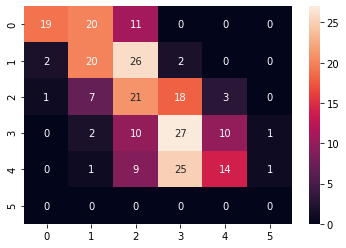

In [284]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(test_y, predictions)
sn.heatmap(cf, annot=True)

In [287]:
emoji_x, emoji_y = load_data('../plots/predict')
emoji_x = emoji_x.reshape(-1, 48, 48, 1)
emoji_pred = trained_model.predict(emoji_x)
# y = np.argmax(predictions, axis=1)
# print(y)
print(emoji_y)
# emoji_pred = np.uint8(np.round(emoji_pred)).flatten()
emoji_pred = emoji_pred.flatten()
# predictions[predictions>=6] = 6
# predictions[predictions<=1] = 2
print(emoji_pred)

(5, 48, 48)
(5,)
[2. 2. 2. 4. 4.]
[4.817904  5.4316936 5.052975  3.8388755 4.7216563]


In [256]:
def predict_plot(plot_path):
    trained_model = load_model('../saved_model/cnn_reg')
    plot_name = plot_path.split('/')[-1]
    plot_name_split = plot_name.split('_')
    print('number of cluster:', plot_name_split[0])
    plot = get_binary_plot(plot_path)
    resized = cv2.resize(plot, (48,48), interpolation=cv2.INTER_AREA) # resize to 32 * 32
    scaled = resized/255.0 # rescale
    scaled = scaled.reshape(-1, 48, 48, 1)
    pred = trained_model.predict(scaled)
    print('predict:', pred)
    

In [294]:
predict_plot('../plots/predict/unknow_5.png')

number of cluster: unknow
predict: [[2.456901]]
